# xử lý outliers

## Data

### Load data

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Tải dữ liệu
df = pd.read_csv('data/train.csv')

### Missing values

In [6]:


# Xử lý missing values
print("Missing values trước xử lý:")
print(df[['Age', 'Fare', 'SibSp', 'Parch']].isnull().sum())
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Fare'].fillna(df['Fare'].mean(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df.drop('Cabin', axis=1, inplace=True)
print("\nMissing values sau xử lý:")
print(df[['Age', 'Fare', 'SibSp', 'Parch']].isnull().sum())

# Kiểm tra duplicates
print(f"\nDuplicates: {df.duplicated().sum()}")

Missing values trước xử lý:
Age      177
Fare       0
SibSp      0
Parch      0
dtype: int64

Missing values sau xử lý:
Age      0
Fare     0
SibSp    0
Parch    0
dtype: int64

Duplicates: 0


C:\Users\ThaiTu\AppData\Local\Temp\ipykernel_33644\126618065.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
C:\Users\ThaiTu\AppData\Local\Temp\ipykernel_33644\126618065.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

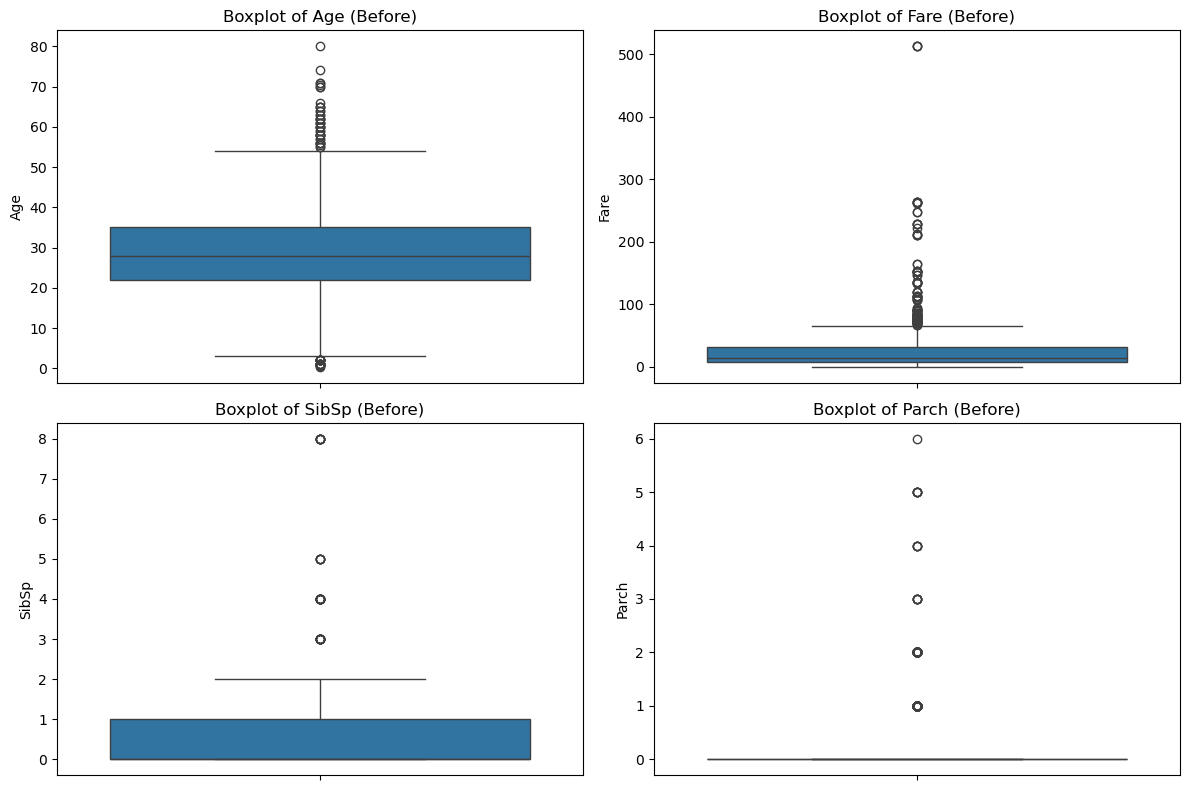

Age - Outliers (IQR): 66, Lower: 2.50, Upper: 54.50
Fare - Outliers (IQR): 116, Lower: -26.72, Upper: 65.63
SibSp - Outliers (IQR): 46, Lower: -1.50, Upper: 2.50
Parch - Outliers (IQR): 213, Lower: 0.00, Upper: 0.00


In [7]:
# Bước 2: Trực quan hóa outliers
num_cols = ['Age', 'Fare', 'SibSp', 'Parch']
plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols):
    plt.subplot(2, 2, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col} (Before)')
plt.tight_layout()
plt.savefig('outliers_before.png', dpi=300)  # Lưu cho paper/slide
plt.show()

# Hàm phát hiện outliers bằng IQR
def detect_outliers_iqr(df, col, factor=1.5):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f'{col} - Outliers (IQR): {len(outliers)}, Lower: {lower_bound:.2f}, Upper: {upper_bound:.2f}')
    return outliers, lower_bound, upper_bound

# Phát hiện outliers
for col in num_cols:
    detect_outliers_iqr(df, col)

In [12]:
# Bước 3: Xử lý outliers
# Capping bằng IQR cho Age và Fare
for col in ['Age', 'Fare']:
    _, lower, upper = detect_outliers_iqr(df, col)
    df[col] = df[col].clip(lower=lower, upper=upper)

# Log transform cho Fare
df['Fare_log'] = np.log1p(df['Fare'])

# Kiểm tra SibSp/Parch
for col in ['SibSp', 'Parch']:
    outliers, _, _ = detect_outliers_iqr(df, col)
    if len(outliers) / len(df) < 0.05:  # Ít hơn 5%, giữ nguyên
        print(f'{col}: Keeping outliers (contextually meaningful)')
    else:
        df[col] = df[col].clip(lower=0, upper=df[col].quantile(0.95))

Age - Outliers (IQR): 0, Lower: 2.50, Upper: 54.50
Fare - Outliers (IQR): 0, Lower: -26.72, Upper: 65.63
SibSp - Outliers (IQR): 46, Lower: -1.50, Upper: 2.50
Parch - Outliers (IQR): 213, Lower: 0.00, Upper: 0.00


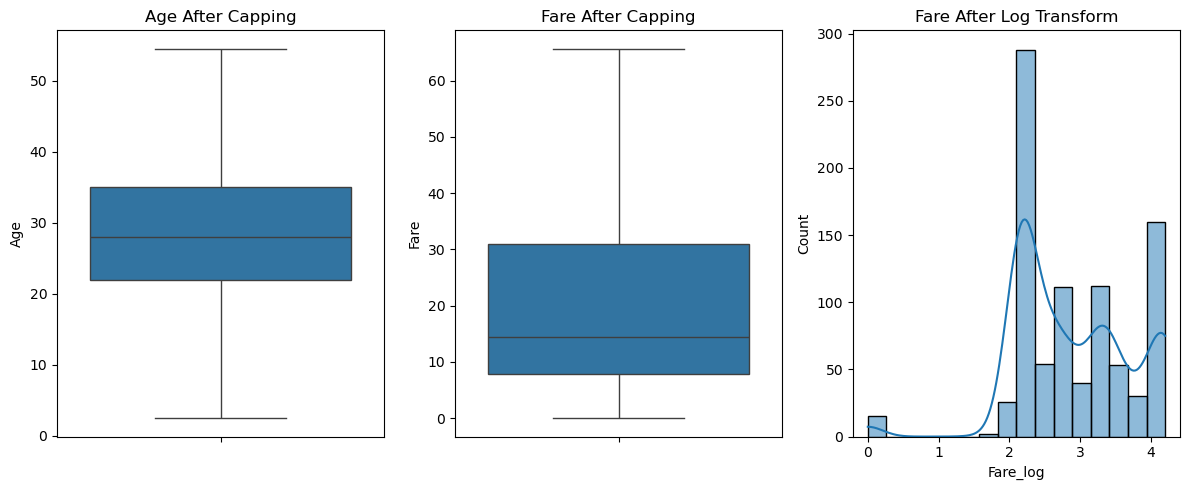


Describe sau xử lý:
              Age        Fare       SibSp       Parch
count  891.000000  891.000000  891.000000  891.000000
mean    29.039282   24.046813    0.452301    0.345679
std     12.072074   20.481625    0.788059    0.663266
min      2.500000    0.000000    0.000000    0.000000
25%     22.000000    7.910400    0.000000    0.000000
50%     28.000000   14.454200    0.000000    0.000000
75%     35.000000   31.000000    1.000000    0.000000
max     54.500000   65.634400    3.000000    2.000000

Dataset sạch đã được lưu vào 'train_clean_outliers.csv'


In [13]:
# Bước 4: Kiểm tra sau xử lý
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
sns.boxplot(y=df['Age'])
plt.title('Age After Capping')
plt.subplot(1, 3, 2)
sns.boxplot(y=df['Fare'])
plt.title('Fare After Capping')
plt.subplot(1, 3, 3)
sns.histplot(df['Fare_log'], kde=True)
plt.title('Fare After Log Transform')
plt.tight_layout()
plt.savefig('outliers_after.png', dpi=300)
plt.show()

# So sánh describe
print("\nDescribe sau xử lý:")
print(df[['Age', 'Fare', 'SibSp', 'Parch']].describe())

# Lưu dataset sạch
df.to_csv('train_clean_outliers.csv', index=False)
print("\nDataset sạch đã được lưu vào 'train_clean_outliers.csv'")